# Importing the libraries and the required files

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [5]:
#Import the data file 

df = pd.read_excel("D:\models\datasets\Sample - Superstore.xls",parse_dates=True)

In [7]:
#checking the shape of the dataframe
df.shape

(9994, 21)

In [8]:
#From the list of categories selecting only the Furnitures
furniture = df.loc[df['Category'] == 'Furniture']

In [10]:
#checking the shape of the dataframe
furniture.shape

(2121, 21)

In [11]:
##checking the minimum and the maximum timestamp present in the furniture category 
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

# Data Preprocessing

#Removing columns we do not need, check missing values, aggregate sales by date and so on

In [12]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 
        'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 
        'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']

furniture.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')

furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [13]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [15]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


Indexing with Time Series Data

In [16]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [17]:
# we will use the averages daily sales value for the month instead, 
# and we are using the start of each month as the timestamp.

y = furniture['Sales'].resample('MS').mean()

In [19]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

# Visualizing Furniture Sales Time Series Data

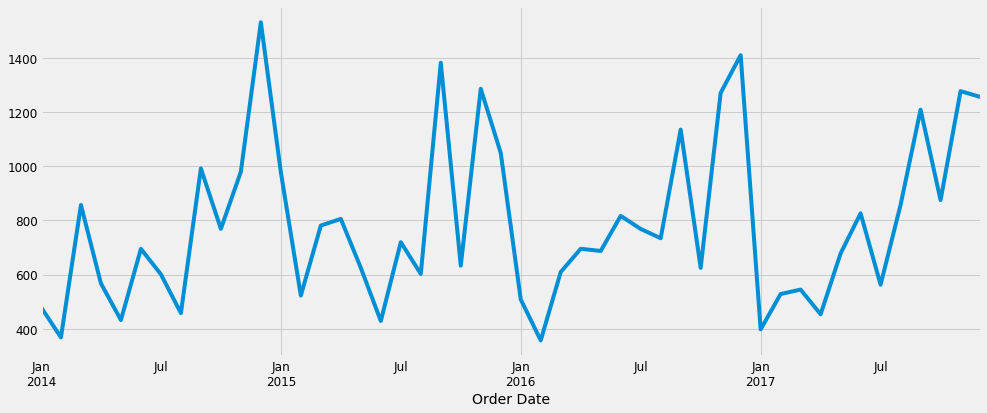

In [20]:
y.plot(figsize=(15, 6))
plt.show()

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise

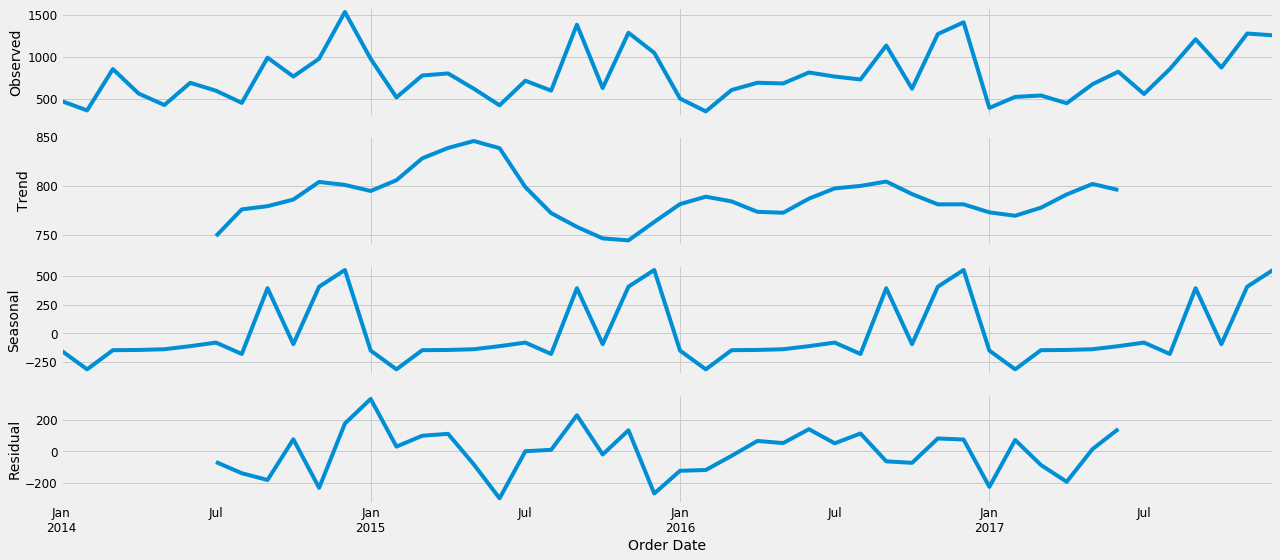

In [21]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# Time series forecasting with ARIMA

ARIMA - Autoregressive Integrated Moving Average

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.

here are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:

p- is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.

d- is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.

q- is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. In the next section, we will describe how to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model.



In [22]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Parameter Selection for the ARIMA Time Series Model

When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest. 
There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. 

In this section, we will resolve this issue by writing Python code to programmatically select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.

We will use a "grid search" to iteratively explore different combinations of parameters. 

For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. 

Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest.

Let's begin by generating the various combination of parameters that we wish to assess:


We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. In Statistics and Machine Learning, this process is known as grid search (or hyperparameter optimization) for model selection.

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.

In [28]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1131.2657078645939
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1001.3915524374769
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758095
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2876.7174897071977
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091255


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.54290594685824
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2461.517421827548
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468657


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1287.5697512865586
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1388.8924232046936
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176816999
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3307.7208814993064
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482932
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.18329774427826
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2625.602326434297
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.75743684172994
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1399.3709974017943
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.92593679352177
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1431.0752736869172
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084554
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.779444218685
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:246116.34689777798
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3685195814987
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323876739
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:3365796.8535189056
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.0156002122138
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1393.2157168383435
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.2003422281134
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.34036587848493
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:2102.468501404909
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.6270901345443
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835024
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2603.9208285600357
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.4762687610111
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.52503546608614
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2586.7750340396897
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.7875439553055


The output of our code suggests that SARIMA(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 297.78. We should therefore consider this to be optimal option out of all the models we have considered.

# Fitting an ARIMA Time Series Model

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We will start by plugging the optimal parameter values into a new SARIMAX model:

In [30]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. 

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

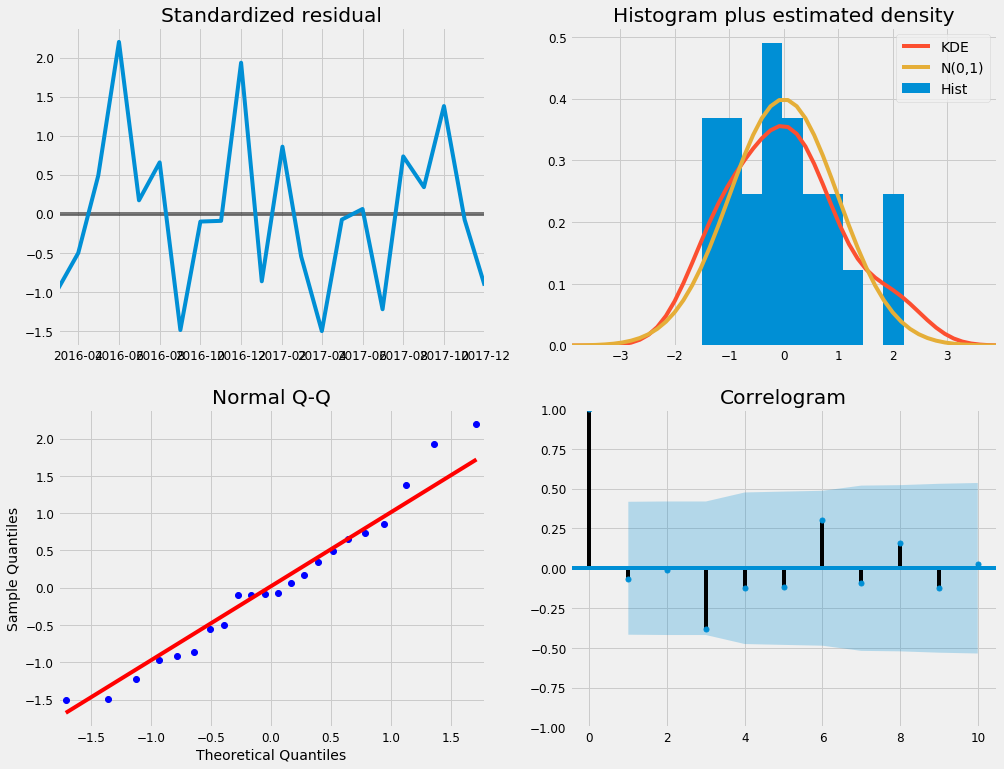

In [31]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

# Validating Forecasts

We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. 

The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [33]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

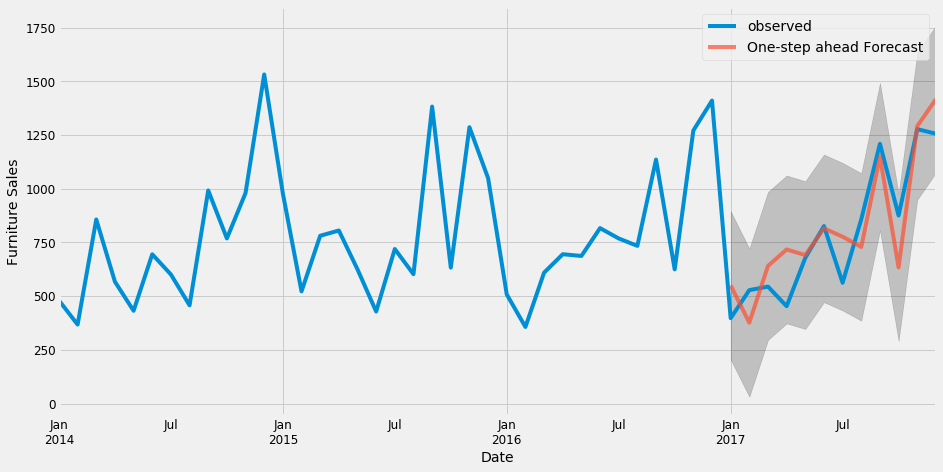

In [34]:
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [35]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.58


In [36]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


# Producing and visualizing forecasts

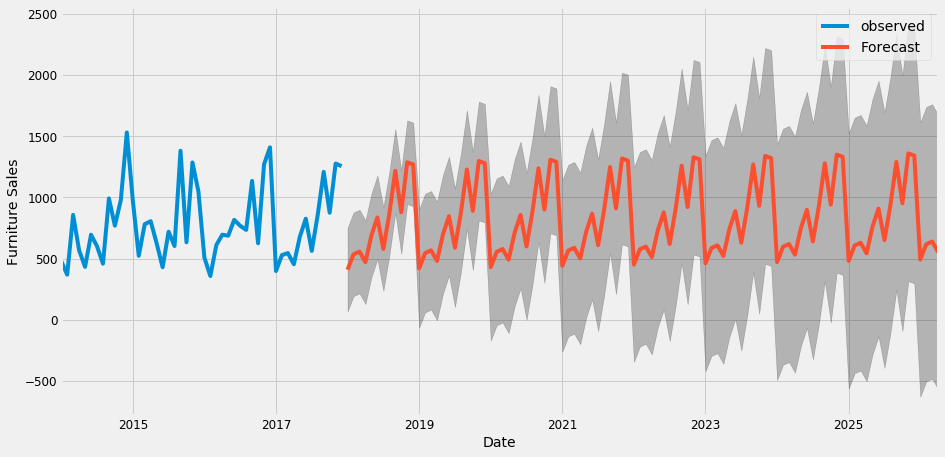

In [37]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()